<a href="https://colab.research.google.com/github/JeanMusenga/PhD-Thesis_2024_Musenga/blob/main/MLClassifier_with_GridSearchCV_10_fold_cross_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://chatgpt.com/share/31751243-a735-41ad-b1a6-0e7952f9b67e

# 1. Import libraries

In [1]:
import pandas as pd

In [18]:
# Load the dataset
df = pd.read_excel('posts.xlsx')


In [19]:
class_distribution = df['Label'].value_counts()
print(class_distribution)

Label
1    4990
0    4990
Name: count, dtype: int64


In [20]:
class_distribution_percentage = df['Label'].value_counts(normalize=True) * 100
print(class_distribution_percentage)


Label
1    50.0
0    50.0
Name: proportion, dtype: float64


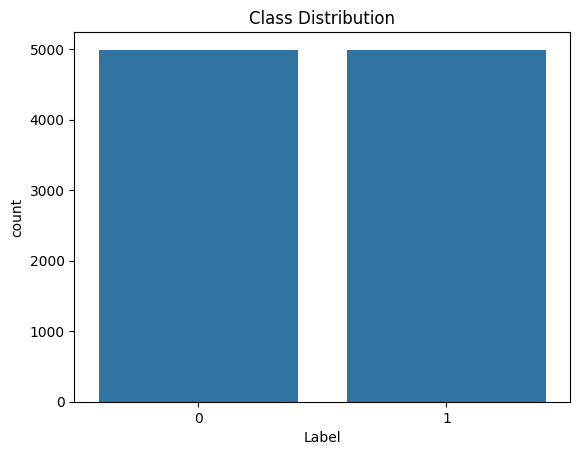

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Label', data=df)
plt.title('Class Distribution')
plt.show()


# 2. Preprocess the Text Data

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')
nltk.download('stopwords')

# Text preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['processed_text'] = df['Question_body'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 3. Train a Word2Vec Model

In [23]:
from gensim.models import Word2Vec

# Train Word2Vec on the preprocessed text
sentences = df['processed_text'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


# 4. Vectorize the Text Data

In [24]:
import numpy as np

def vectorize_text(text, model, vector_size):
    vec = np.zeros(vector_size)
    count = 0
    for word in text:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    return vec

X = np.array([vectorize_text(text, word2vec_model, 100) for text in sentences])
y = df['Label'].values


# 5. Train SVM with 10-Fold Cross-Validation

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

# Define models with their respective parameter grids
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'k-Nearest Neighbor': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# Define models without parameters (they will be tuned via GridSearch)
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': BernoulliNB(),
    'k-Nearest Neighbor': KNeighborsClassifier()
}

# Perform GridSearchCV and 10-fold cross-validation for each model
for name, model in models.items():
    print(f"--- {name} ---")

    # Setup GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Perform 10-fold cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=10)

    # Print classification report
    print(classification_report(y, y_pred))
    print("\n")


--- SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4990
           1       0.96      0.98      0.97      4990

    accuracy                           0.97      9980
   macro avg       0.97      0.97      0.97      9980
weighted avg       0.97      0.97      0.97      9980



--- Logistic Regression ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4990
           1       0.96      0.98      0.97      4990

    accuracy                           0.97      9980
   macro avg       0.97      0.97      0.97      9980
weighted avg       0.97      0.97      0.97      9980



--- Decision Tree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Be

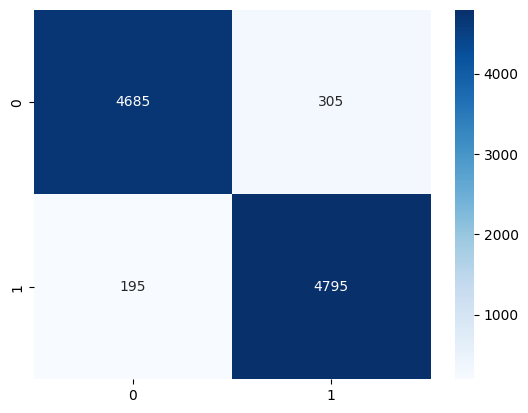

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      4990
           1       0.94      0.96      0.95      4990

    accuracy                           0.95      9980
   macro avg       0.95      0.95      0.95      9980
weighted avg       0.95      0.95      0.95      9980



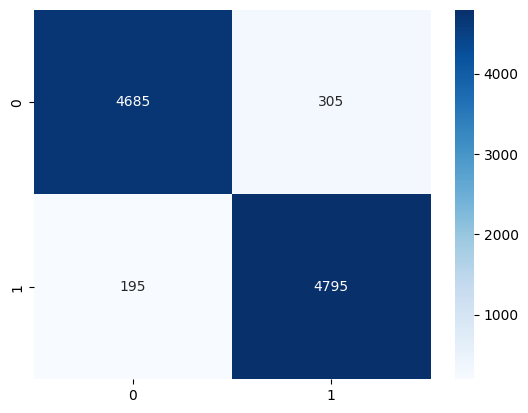

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Example with the best SVM model
y_pred = cross_val_predict(best_model, X, y, cv=10)

# Classification report
print(classification_report(y, y_pred))

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


--- SVM ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 10, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4990
           1       0.96      0.98      0.97      4990

    accuracy                           0.97      9980
   macro avg       0.97      0.97      0.97      9980
weighted avg       0.97      0.97      0.97      9980



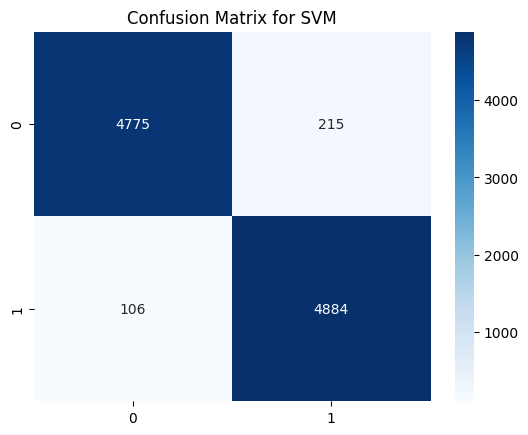

ROC-AUC Score for SVM: 0.9926


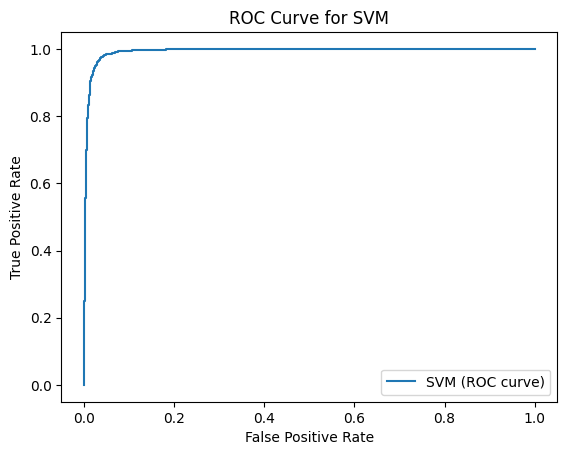

--- Logistic Regression ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'C': 10, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4990
           1       0.96      0.98      0.97      4990

    accuracy                           0.97      9980
   macro avg       0.97      0.97      0.97      9980
weighted avg       0.97      0.97      0.97      9980



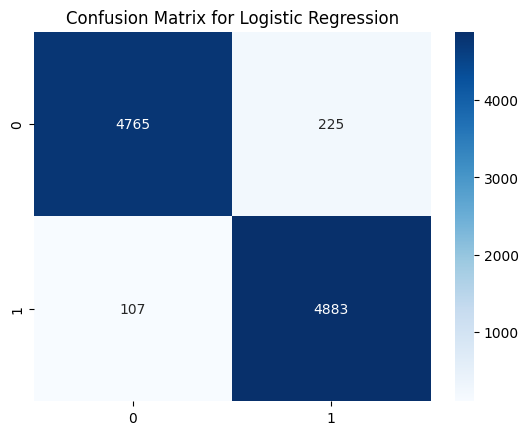

ROC-AUC Score for Logistic Regression: 0.9922


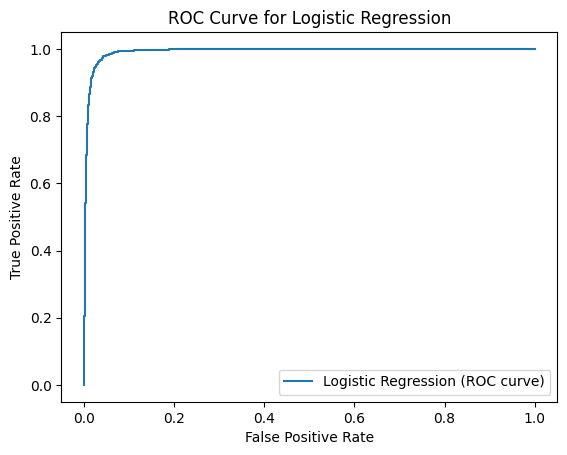

--- Decision Tree ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4990
           1       0.93      0.93      0.93      4990

    accuracy                           0.93      9980
   macro avg       0.93      0.93      0.93      9980
weighted avg       0.93      0.93      0.93      9980



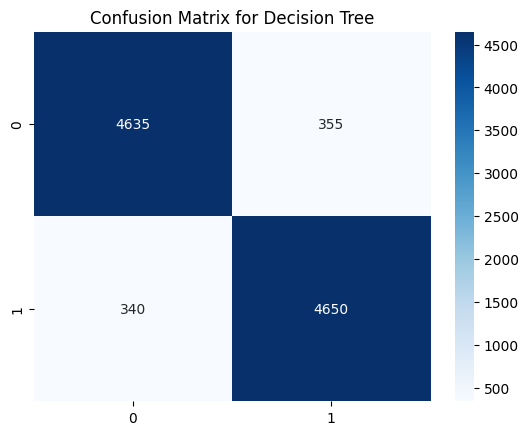

ROC-AUC Score for Decision Tree: 0.9125


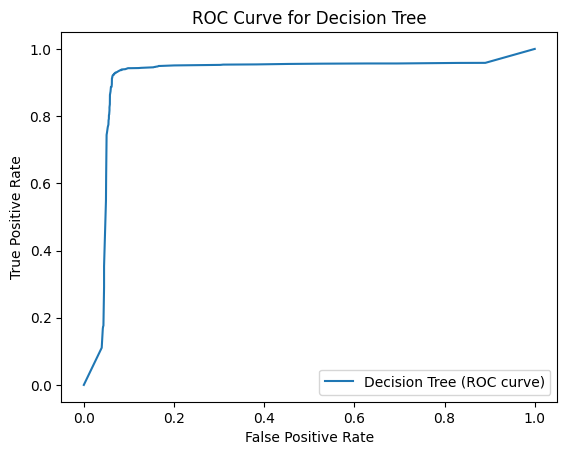

--- Naive Bayes ---
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'alpha': 0.1}
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      4990
           1       0.88      0.96      0.92      4990

    accuracy                           0.91      9980
   macro avg       0.92      0.91      0.91      9980
weighted avg       0.92      0.91      0.91      9980



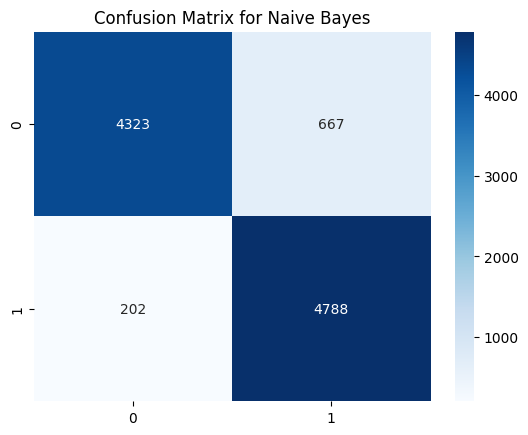

ROC-AUC Score for Naive Bayes: 0.9748


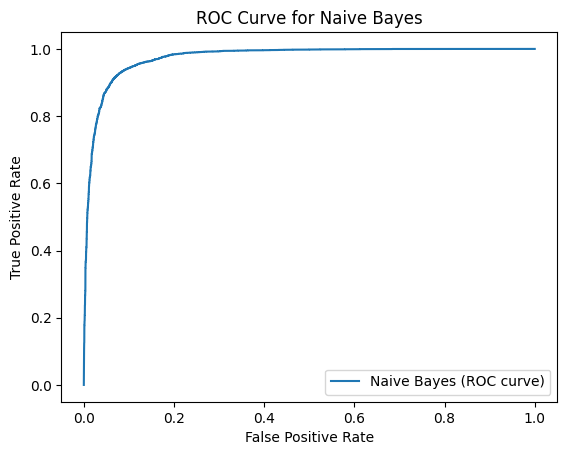

--- k-Nearest Neighbor ---
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4990
           1       0.94      0.96      0.95      4990

    accuracy                           0.95      9980
   macro avg       0.95      0.95      0.95      9980
weighted avg       0.95      0.95      0.95      9980



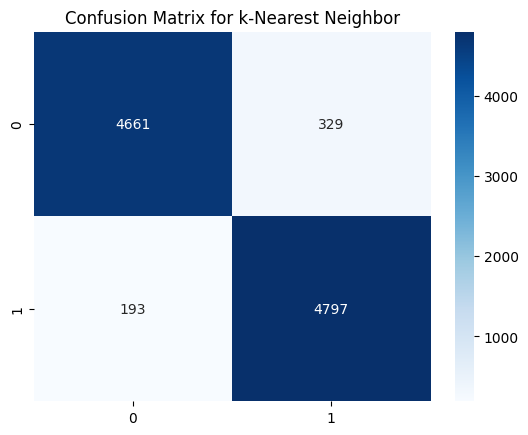

ROC-AUC Score for k-Nearest Neighbor: 0.9783


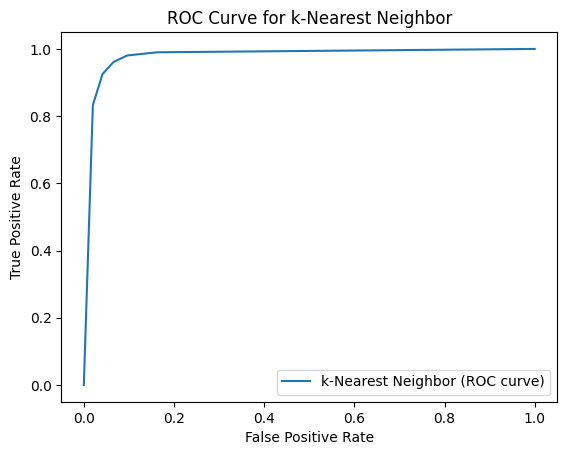

In [27]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Define models with their respective parameter grids
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'k-Nearest Neighbor': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# Define models without parameters (they will be tuned via GridSearch)
models = {
    'SVM': SVC(probability=True),  # Set probability=True for ROC curve
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': BernoulliNB(),
    'k-Nearest Neighbor': KNeighborsClassifier()
}

# Perform GridSearchCV and 10-fold cross-validation for each model
for name, model in models.items():
    print(f"--- {name} ---")

    # Setup GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X, y)

    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best Parameters: {grid_search.best_params_}")

    # Perform 10-fold cross-validation
    y_pred = cross_val_predict(best_model, X, y, cv=10)

    # Print classification report
    print(classification_report(y, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

        # Plot ROC Curve
    if hasattr(best_model, "predict_proba"):
        y_proba = cross_val_predict(best_model, X, y, cv=10, method='predict_proba')
        roc_auc = roc_auc_score(y, y_proba[:, 1])
        print(f"ROC-AUC Score for {name}: {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (ROC curve)')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='best')
        plt.show()
